# HW1 - KNN (K-nearest neighbors)

We're going to solve the some problems using one of the simplest machine learning algorithms based on supervised learning technique - K-nearest neighbors:
* binary classification
* multiclass classification
* regression

We will have to choose hyperparameter - number of neighbors, k.

In [1]:
# %load_ext autoreload
# %autoreload 2
# %load_ext pycodestyle_magic
# %flake8_on --max_line_length=120

import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from knn import KNNClassifier
from metrics import binary_classification_metrics, multiclass_accuracy
from sklearn.neighbors import (KNeighborsRegressor,
                               KNeighborsClassifier)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

## Exercise 1 - KNN on dataset Fashion-MNIST

We take a dataset Fashion-MNIST out of sklearn.datasets. This dataset contains picture of clothing and can be divided into 10 classes. In variable X 70000 28x28 pixel pictures are stored and stretched into a vector of size 784 (28 * 28). We have to take 1000 random pictures.

In [3]:
data = fetch_openml(name="Fashion-MNIST")

In [4]:
X, y = fetch_openml(name="Fashion-MNIST", return_X_y=True, as_frame=False)

In [5]:
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=1000)
X = X[idx_to_stay]
y = y[idx_to_stay]

(-0.5, 27.5, 27.5, -0.5)

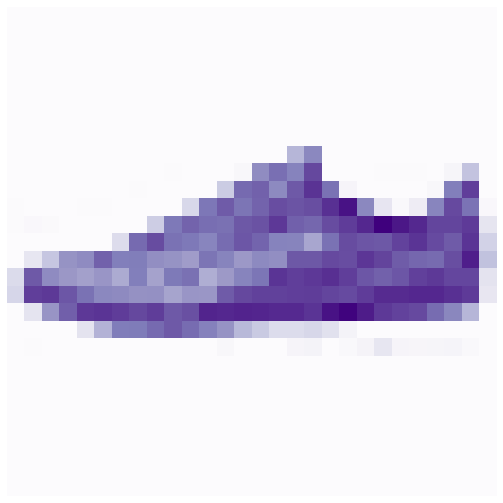

In [6]:
# Taking random picture
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28, 1)
plt.imshow(image, cmap='Purples')
plt.axis("off")

### 1.1 Let's take a look at all the classes (0.5 points)

Unique number of classes:

In [7]:
set(y)

{'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}

Another method:

In [8]:
np.unique(data.target[idx_to_stay])

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

Randomly choosing the number of the row:

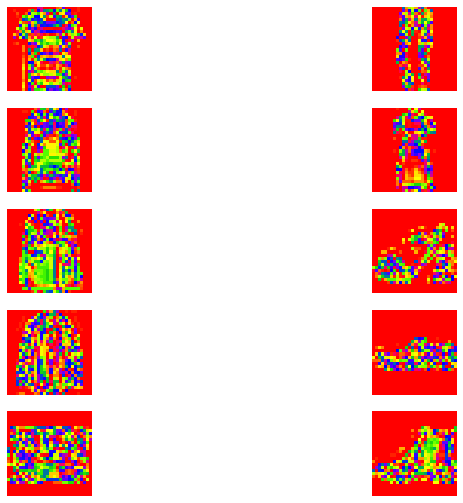

In [9]:
fig, axs = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True)
for i, c in enumerate(np.unique(data.target[idx_to_stay])):
    if i % 2 == 0:
        image = X[np.random.choice(np.where(y == c)[0])].reshape(28, 28, 1)
        axs[i//2, 0].imshow(image, cmap='prism')
        axs[i//2, 0].axis("off")
    else:
        image = X[np.random.choice(np.where(y == c)[0])].reshape(28, 28, 1)
        axs[i//2, 1].imshow(image, cmap='prism')
        axs[i//2, 1].axis("off")


plt.show()

### 1.2 Doing EDA (1 point)

Checking the number of classes in each group:

In [10]:
data.target[idx_to_stay].value_counts()

3    121
8    109
9    106
1    102
6    101
5     98
4     96
2     95
0     93
7     79
Name: class, dtype: int64

Seems that some classes are overrepresented or underrepresented, let's try to sample equally. First check what was the ratio in the primary data:

In [11]:
data.target.value_counts()

0    7000
1    7000
2    7000
3    7000
4    7000
5    7000
6    7000
7    7000
8    7000
9    7000
Name: class, dtype: int64

Seems the ratio of classes was the same.

In [12]:
df = pd.concat([data.data, data.target], axis=1)
sample_df = df.groupby('class').apply(lambda x: x.sample(frac=0.1))  # .sample() does it without replacement, no worries

In [13]:
sample_df.loc[:, "class"].value_counts()

0    700
1    700
2    700
3    700
4    700
5    700
6    700
7    700
8    700
9    700
Name: class, dtype: int64

Now the sampling makes more sense.

In [14]:
X = np.array(sample_df.loc[:, df.columns != "class"], dtype='int16')
y = np.array(sample_df.loc[:, "class"], dtype='int16')

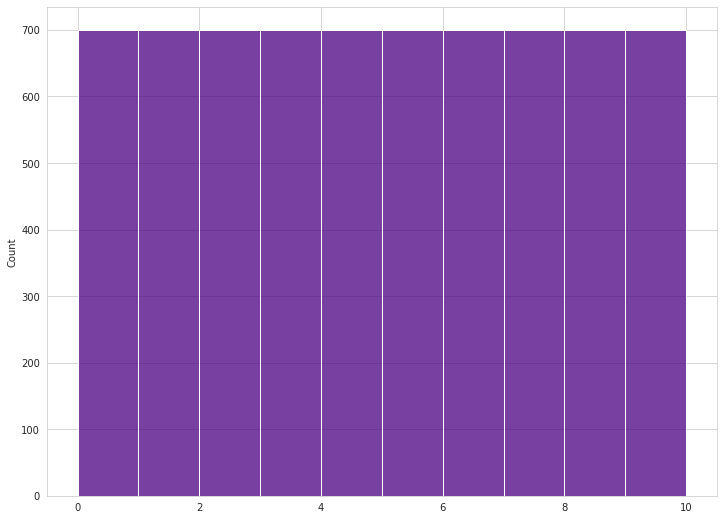

In [15]:
sns.histplot(y, color="#4B0082", binwidth=1, binrange=(0, 10))
plt.show()

### 1.3 Divide the dataset into train and test data (0.5 points)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

### 1.4 KNN for binary classification 

Select objects from classes 0 and 1:

In [17]:
idx_train_0_1 = np.where((y_train == 0) | (y_train == 1))[0]
bin_y_train = y_train[idx_train_0_1]
bin_X_train = X_train[idx_train_0_1]
scaler = StandardScaler()
bin_X_train = scaler.fit_transform(bin_X_train)

In [18]:
idx_test_0_1 = np.where((y_test == 0) | (y_test == 1))[0]
bin_y_test = y_test[idx_test_0_1]
bin_X_test = X_test[idx_test_0_1]
bin_X_test = scaler.transform(bin_X_test)

For KNN Binary Classification we are creating a pair-distance matrix of train and test data. We are writing the code for computation of [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2), otherwise also called L1, in the methods `compute_distances_two_loops`, `compute_distances_one_loop` and `compute_distances_no_loops` of the class `KNN` in the file `knn.py`.


$d_{1}(\mathbf {p} ,\mathbf {q} )=\|\mathbf {p} -\mathbf {q} \|_{1}=\sum _{i=1}^{n}|p_{i}-q_{i}|$ 

In [19]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(bin_X_train, bin_y_train)

Checking that the functions are all working:

In [20]:
# TODO: compute_distances_two_loops
dists = knn_classifier.compute_distances_two_loops(bin_X_test)
assert np.isclose(dists[0, 100], np.sum(np.abs(bin_X_test[0] - bin_X_train[100])))

In [21]:
# TODO: compute_distances_one_loop
dists = knn_classifier.compute_distances_one_loop(bin_X_test)
assert np.isclose(dists[0, 100], np.sum(np.abs(bin_X_test[0] - bin_X_train[100])))

In [22]:
# TODO: compute_distances_one_loop
dists = knn_classifier.compute_distances_no_loops(bin_X_test)
assert np.isclose(dists[0, 100], np.sum(np.abs(bin_X_test[0] - bin_X_train[100])))

Checking the time performance:

In [23]:
%timeit knn_classifier.compute_distances_two_loops(bin_X_test)
%timeit knn_classifier.compute_distances_one_loop(bin_X_test)
%timeit knn_classifier.compute_distances_no_loops(bin_X_test)

1.19 s ± 28.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
436 ms ± 2.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
824 ms ± 1.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


According to this, the one-loop computation is the fastest.

Write the function for prediction of the class:

In [24]:
# TODO: predict_labels_binary in knn.py
prediction = knn_classifier.predict(bin_X_test, n_loops=1)

### Metrics

In [25]:
precision, recall, accuracy, f1 = binary_classification_metrics(prediction, bin_y_test)

Checking the metrics with `sklearn`
<img src="https://i.imgflip.com/406fu9.jpg" width="800" height="400">

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print(f"Precision: {precision_score(bin_y_test, prediction)}")
print(f"Recall: {recall_score(bin_y_test, prediction)}")
print(f"Accuracy: {accuracy_score(bin_y_test, prediction)}")
print(f"F1: {f1_score(bin_y_test, prediction)}")

Precision: 0.9856115107913669
Recall: 0.9785714285714285
Accuracy: 0.9821428571428571
F1: 0.9820788530465949


Matches.

I'm now also going to check whether my function works the same as from sklearn.

In [27]:
knn_pipeline = Pipeline(steps=[("scaler", StandardScaler()),
                               ("knn_class", KNeighborsClassifier(n_neighbors=1, n_jobs=16,
                                                                  metric="manhattan"))])
knn_pipeline.fit(bin_X_train, bin_y_train)
y_pred = knn_pipeline.predict(bin_X_test)

In [28]:
np.where(prediction != y_pred)

(array([], dtype=int64),)

In [29]:
knn_pipeline = Pipeline(steps=[("knn_class", KNeighborsClassifier(n_neighbors=1, n_jobs=16,
                                                                  metric="manhattan"))])
knn_pipeline.fit(bin_X_train, bin_y_train)
y_pred = knn_pipeline.predict(bin_X_test)

In [30]:
np.where(prediction != y_pred)

(array([], dtype=int64),)

Let's check the stats:

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print(f"Precision: {precision_score(bin_y_test, y_pred)}")
print(f"Recall: {recall_score(bin_y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(bin_y_test, y_pred)}")
print(f"F1: {f1_score(bin_y_test, y_pred)}")

Precision: 0.9856115107913669
Recall: 0.9785714285714285
Accuracy: 0.9821428571428571
F1: 0.9820788530465949


Why and how?

### Chossing optimal k

Take a couple of possible values of k and checking the best one.

In [32]:
def find_best_k(X_train, y_train, X_test, y_test, params):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    train_metrics = pd.DataFrame(columns=["Precision", "Recall", "Accuracy", "F1"])
    test_metrics = pd.DataFrame(columns=["Precision", "Recall", "Accuracy", "F1"])

    for i, k in enumerate(params):
        # Creating model
        knn_classifier = KNNClassifier(k=k)
        knn_classifier.fit(X_train, y_train)

        # Train
        y_pred = knn_classifier.predict(X_train, n_loops=1)
        precision, recall, accuracy, f1 = binary_classification_metrics(y_pred, y_train)
        train_metrics.loc[i] = [precision, recall, accuracy, f1]

        # Test
        y_pred = knn_classifier.predict(X_test, n_loops=1)
        precision, recall, accuracy, f1 = binary_classification_metrics(y_pred, y_test)
        test_metrics.loc[i] = [precision, recall, accuracy, f1]

    return train_metrics, test_metrics

In [33]:
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k(bin_X_train, bin_y_train, bin_X_test, bin_y_test, params)

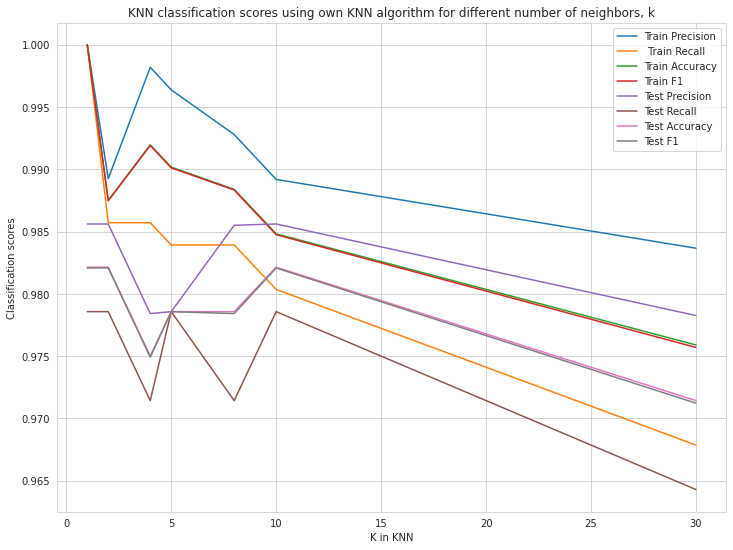

3:121: E501 line too long (139 > 120 characters)
6:100: E703 statement ends with a semicolon


In [34]:
plt.plot(params, train_metrics)
plt.plot(params, test_metrics)
plt.legend(["Train Precision", " Train Recall", "Train Accuracy", "Train F1", "Test Precision", "Test Recall", "Test Accuracy", "Test F1"])
plt.xlabel("K in KNN")
plt.ylabel("Classification scores")
plt.title("KNN classification scores using own KNN algorithm for different number of neighbors, k");

Text(0.5, 1.0, 'KNN classification accuracy scores using own KNN algorithm for different number of neighbors, k')

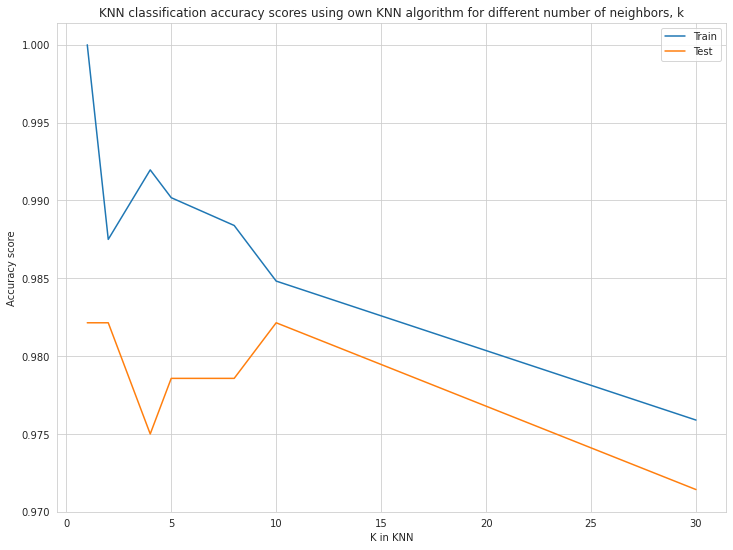

In [35]:
plt.plot(params, train_metrics["Accuracy"], label='Train')
plt.plot(params, test_metrics["Accuracy"], label='Test')
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Accuracy score")
plt.title("KNN classification accuracy scores using own KNN algorithm for different number of neighbors, k")

Checking with sklearn.

In [88]:
def sklearn_find_best_k(X_train, y_train, X_test, y_test, params):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    train_metrics = pd.DataFrame(columns=["Precision", "Recall", "Accuracy", "F1"])
    test_metrics = pd.DataFrame(columns=["Precision", "Recall", "Accuracy", "F1"])

    for i, k in enumerate(params):
        # Creating model
        knn_pipeline = Pipeline(steps=[("scaler", StandardScaler()),
                                       ("knn_reg", KNeighborsClassifier(n_neighbors=k, n_jobs=16,
                                                                        metric="manhattan"))])
        knn_pipeline.fit(X_train, y_train)

        # Train
        y_pred = knn_pipeline.predict(X_train)
        precision = precision_score(y_train, y_pred)
        recall = recall_score(y_train, y_pred)
        accuracy = accuracy_score(y_train, y_pred)
        f1 = f1_score(y_train, y_pred)
        train_metrics.loc[i] = [precision, recall, accuracy, f1]

        # Test
        y_pred = knn_pipeline.predict(X_test)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        test_metrics.loc[i] = [precision, recall, accuracy, f1]

    return train_metrics, test_metrics

In [85]:
params = [1, 2, 4, 5, 8, 10, 30]
sklearn_train_metrics, sklearn_test_metrics = sklearn_find_best_k(bin_X_train, bin_y_train,
                                                                  bin_X_test, bin_y_test, params)

Text(0.5, 1.0, 'KNN classification scores using sklearn KNN algorithm for different number of neighbors, k')

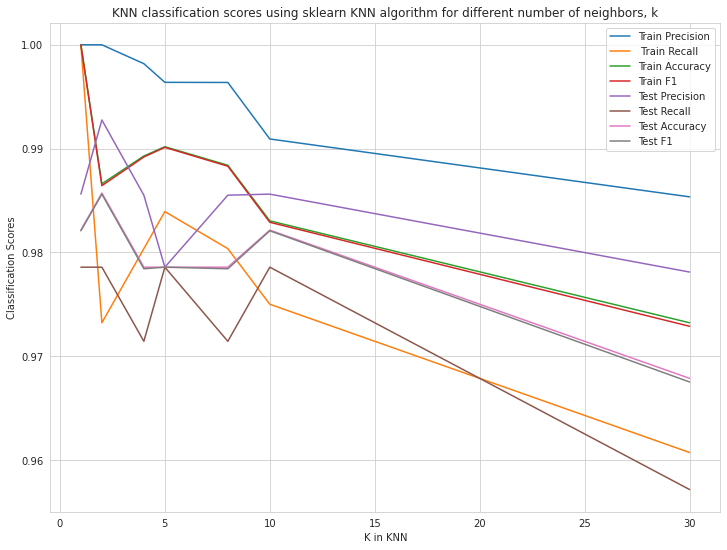

In [86]:
plt.plot(params, sklearn_train_metrics)
plt.plot(params, sklearn_test_metrics)
plt.legend(["Train Precision", " Train Recall", "Train Accuracy", "Train F1",
            "Test Precision", "Test Recall", "Test Accuracy", "Test F1"])
plt.xlabel("K in KNN")
plt.ylabel("Classification Scores")
plt.title("KNN classification scores using sklearn KNN algorithm for different number of neighbors, k")

Text(0.5, 1.0, 'KNN classification accuracy scores using sklearn KNN algorithm for different number of neighbors, k')

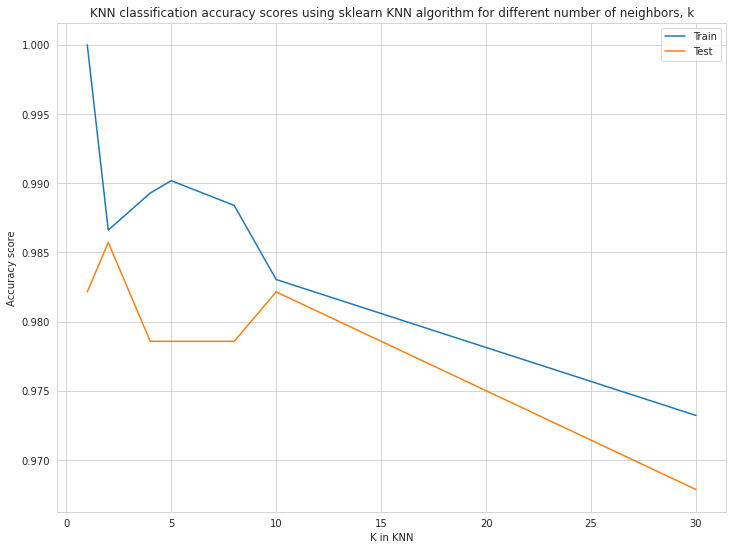

In [39]:
plt.plot(params, sklearn_train_metrics["Accuracy"], label='Train')
plt.plot(params, sklearn_test_metrics["Accuracy"], label='Test')
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Accuracy score")
plt.title("KNN classification accuracy scores using sklearn KNN algorithm for different number of neighbors, k")


 **Which metrics to choose?** 
 
 Here false positives and false negatives (thus, precision and recall, respectively) don't matter that much, in the sense there are both valuable metrics the same way (not e.g. in the way, how recall, false negatives, is important when detecting sick patient or precision, false positives, is important metrics for spam email). As true negatives as well as true positives are valuable here, accuracy is the best choice and better than F1.
 
 **Which k - count of neighbors should we choose?**
 
According to the figure from own and sklearn algorithm the accuracy score is the highest for test X values for k=10, which is why I would choose 10 neighbors.

### 1.5 Multiclass classification

Now we take all 10 classes!

In [40]:
mult_scaler = StandardScaler()
X_train = mult_scaler.fit_transform(X_train)
X_test = mult_scaler.transform(X_test)

In [41]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_train, y_train)

In [42]:
predictions = knn_classifier.predict(X_test, n_loops=1)

In [43]:
predictions

array([0, 8, 7, ..., 6, 1, 6], dtype=int16)

We wrote the function `multiclass_accuracy` in `metrics.py`.

In [44]:
# TODO: multiclass_accuracy in metrics.py
multiclass_accuracy(predictions, y_test)

0.7928571428571428

Checking with `sklearn`:

In [45]:
knn_pipeline = Pipeline(steps=[("scaler", StandardScaler()),
                               ("knn_class", KNeighborsClassifier(n_neighbors=1, n_jobs=16,
                                                                  metric="manhattan"))])
knn_pipeline.fit(X_train, y_train)
y_pred = knn_pipeline.predict(X_test)

In [46]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")


Accuracy: 0.7928571428571428


Therefore, my formula for accuracy calculation is correct.

In [47]:
def find_mult_best_k(X_train, y_train, X_test, y_test, params):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """

    train_metrics = np.zeros(len(params))
    test_metrics = np.zeros(len(params))

    for i, k in enumerate(params):
        # Creating model
        knn_classifier = KNNClassifier(k=k)
        knn_classifier.fit(X_train, y_train)

        # Train
        y_pred = knn_classifier.predict(X_train, n_loops=1)
        train_metrics[i] = multiclass_accuracy(y_pred, y_train)

        # Test
        y_pred = knn_classifier.predict(X_test, n_loops=1)
        test_metrics[i] = multiclass_accuracy(y_pred, y_test)

    return y_pred, train_metrics, test_metrics

In [48]:
params = [1, 2, 4, 5, 8, 10, 30]
y_pred, train_metrics, test_metrics = find_mult_best_k(X_train, y_train, X_test, y_test, params)

Text(0.5, 1.0, 'KNN multiclass classification accuracy scores using own KNN algorithm for different number of neighbors, k')

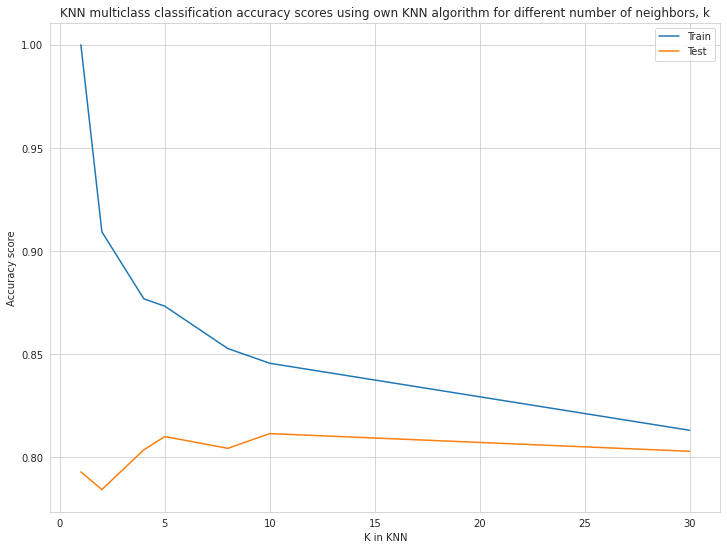

In [49]:
plt.plot(params, train_metrics, label='Train')
plt.plot(params, test_metrics, label='Test')
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Accuracy score")
plt.title("KNN multiclass classification accuracy scores using own KNN algorithm for different number of neighbors, k")

In [50]:
def sklearn_mult_find_best_k(X_train, y_train, X_test, y_test, params):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """

    train_metrics = np.zeros(len(params))
    test_metrics = np.zeros(len(params))

    for i, k in enumerate(params):
        # Creating model
        knn_pipeline = Pipeline(steps=[("scaler", StandardScaler()),
                                       ("knn_class", KNeighborsClassifier(n_neighbors=k, n_jobs=16,
                                                                          metric="manhattan"))])
        knn_pipeline.fit(X_train, y_train)

        # Train
        y_pred = knn_pipeline.predict(X_train)
        train_metrics[i] = accuracy_score(y_train, y_pred)

        # Test
        y_pred = knn_pipeline.predict(X_test)
        test_metrics[i] = accuracy_score(y_test, y_pred)

    return y_pred, train_metrics, test_metrics

In [82]:
params = [1, 2, 4, 5, 8, 10, 30]
sklearn_y_pred, sklearn_train_metrics, sklearn_test_metrics = sklearn_mult_find_best_k(X_train, y_train,
                                                                                       X_test, y_test, params)

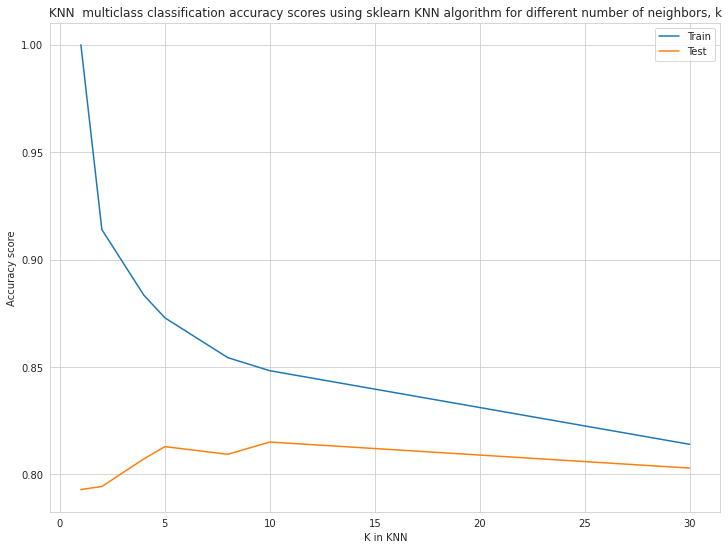

6:121: E501 line too long (125 > 120 characters)
6:125: E703 statement ends with a semicolon


In [52]:
plt.plot(params, sklearn_train_metrics, label='Train')
plt.plot(params, sklearn_test_metrics, label='Test')
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Accuracy score")
plt.title("KNN  multiclass classification accuracy scores using sklearn KNN algorithm for different number of neighbors, k");

 **Which k - count of neighbors should we choose?**
 
According to the figure from own and sklearn algorithm the accuracy score is the highest for test X values for k=10, which is why I would choose 10 neighbors.

## 2.1. KNN on dataset of diabetes (10 points)

In this part of the homework we try to implement KNN for the regression problem. First we load some of the necessary libraries.

In [53]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [54]:
X, y = load_diabetes(as_frame=True, return_X_y=True)

In [55]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


### 2.1 EDA (2 points)

Checking whethere there are some unexpected values in the dataframe:

In [56]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
dtypes: float64(10)
memory usage: 34.7 KB


In [57]:
X.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-3.634285e-16,1.308343e-16,-8.045349e-16,1.281655e-16,-8.835316e-17,1.327024e-16,-4.574646e-16,3.777301e-16,-3.830854e-16,-3.412882e-16
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01


Everything seems okay, the standard deviation of parameters even seems to be the same, and mean is almost zero. However, I would still  bring it to normal distribution of N(0, 1) just to be sure. Now we split data into train and test datasets.

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In this case we have to standardize the dataset in order to ensure every variable has te same scale. Without standardization the variables might end up contributing very differently to the analysis and creating biases. 

In [59]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 2.2 Fitting the regression model (1 point)

Now we fit the model:

In [60]:
neigh = KNeighborsRegressor(n_neighbors=1, n_jobs=16, metric="manhattan")
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

### Pipeline (2 points)

In [81]:
knn_pipeline = Pipeline(steps=[("scaler", StandardScaler()),
                               ("knn_reg", KNeighborsRegressor(n_neighbors=1, n_jobs=16, metric="manhattan"))])
knn_pipeline.fit(X_train, y_train)
y_pred = knn_pipeline.predict(X_test)


### 2.3 Metrics of regression (3 points)

Add functions of $R^2$, MSE and MAE in `metrics.py`.

$R^2 = 1 - \frac{\sum_i^n{(y_i - \hat{y_i})^2}}{\sum_i^n{(y_i - \overline{y})^2}}$

$MSE = \frac{1}{n}\sum_i^n{(y_i - \hat{y_i})^2}$

$MAE = \frac{1}{n}\sum_i^n{|y_i - \hat{y_i}|}$

In [62]:
from metrics import r_squared, mse, mae
print(f"With k = {1} R2 = {r_squared(y_pred, y_test)}")
print(f"With k = {1} MSE = {mse(y_pred, y_test)}")
print(f"With k = {1} MAE = {mae(y_pred, y_test)}")

With k = 1 R2 = -0.12708868051391375
With k = 1 MSE = 5297.820224719101
With k = 1 MAE = 56.17977528089887


Checking our metrics with the metrics from `sklearn`:

In [63]:
print(f"With k = {1} R2 = {r2_score(y_test, y_pred)}")
print(f"With k = {1} MSE = {mean_squared_error(y_test, y_pred)}")
print(f"With k = {1} MAE = {mean_absolute_error(y_test, y_pred)}")


With k = 1 R2 = -0.12708868051391375
With k = 1 MSE = 5297.820224719101
With k = 1 MAE = 56.17977528089887


### 2.4 Choosing optimal k (2 points)

Now we try to find the best k.

In [64]:
def regr_find_best_k(X_train, y_train, X_test, y_test, params):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """

    train_metrics = pd.DataFrame(columns=["R$^2$", "MSE", "MAE"])
    test_metrics = pd.DataFrame(columns=["R$^2$", "MSE", "MAE"])

    for i, k in enumerate(params):
        # Creating model
        knn_pipeline = Pipeline(steps=[("scaler", StandardScaler()),
                                       ("knn_reg", KNeighborsRegressor(n_neighbors=k, n_jobs=16,
                                                                       metric="manhattan"))])
        knn_pipeline.fit(X_train, y_train)

        # Train
        y_pred = knn_pipeline.predict(X_train)
        r2 = r_squared(y_pred, y_train)
        mse = mean_squared_error(y_pred, y_train)
        mae = mean_absolute_error(y_pred, y_train)
        train_metrics.loc[i] = [r2, mse, mae]

        # Test
        y_pred = knn_pipeline.predict(X_test)
        r2 = r_squared(y_pred, y_test)
        mse = mean_squared_error(y_pred, y_test)
        mae = mean_absolute_error(y_pred, y_test)
        test_metrics.loc[i] = [r2, mse, mae]

    return train_metrics, test_metrics

In [65]:
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = regr_find_best_k(X_train, y_train, X_test, y_test, params)

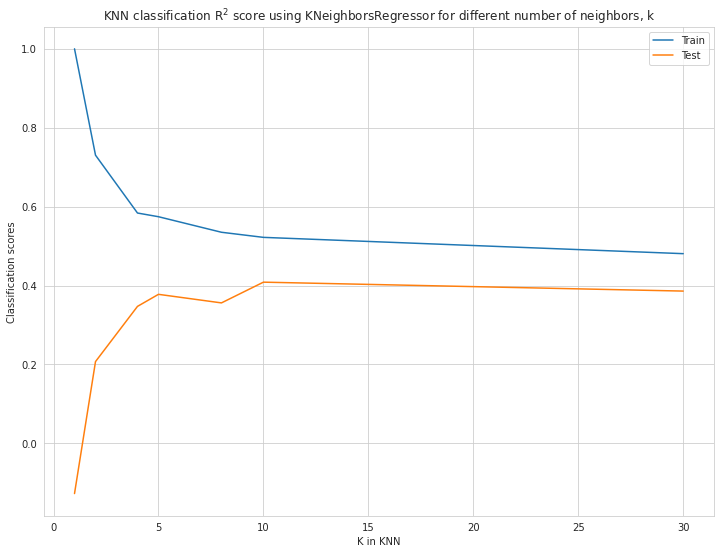

6:107: E703 statement ends with a semicolon


In [66]:
plt.plot(params, train_metrics["R$^2$"], label='Train')
plt.plot(params, test_metrics["R$^2$"], label='Test')
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Classification scores")
plt.title("KNN classification R$^2$ score using KNeighborsRegressor for different number of neighbors, k");

Text(0.5, 1.0, 'KNN classification MSE score using KNeighborsRegressor for different number of neighbors, k')

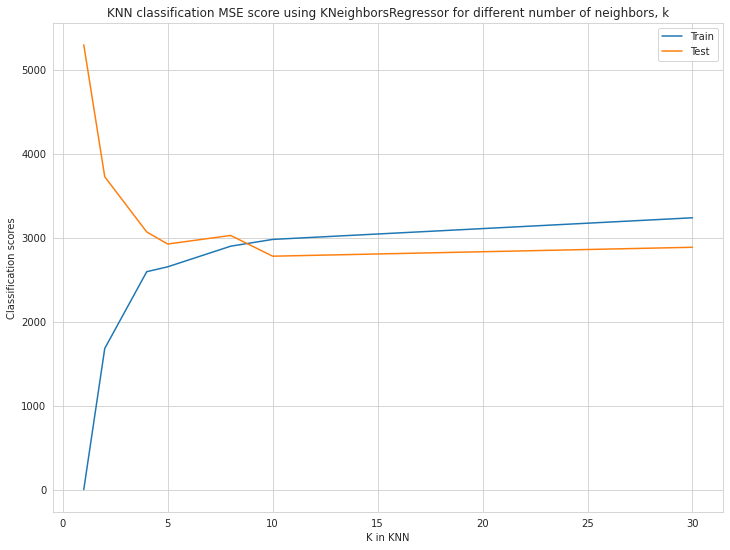

In [67]:
plt.plot(params, train_metrics["MSE"], label='Train')
plt.plot(params, test_metrics["MSE"], label='Test')
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Classification scores")
plt.title("KNN classification MSE score using KNeighborsRegressor for different number of neighbors, k")

Text(0.5, 1.0, 'KNN classification MAE score using KNeighborsRegressor for different number of neighbors, k')

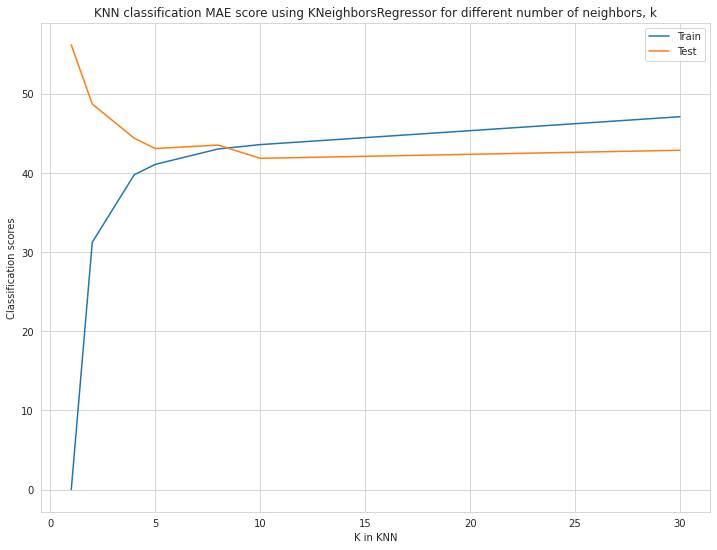

In [68]:
plt.plot(params, train_metrics["MAE"], label='Train')
plt.plot(params, test_metrics["MAE"], label='Test')
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Classification scores")
plt.title("KNN classification MAE score using KNeighborsRegressor for different number of neighbors, k")

 **Which k - count of neighbors should we choose?**
 
According to the figure the R$^2$ score score is the highest for test X values for k=10, and MSE and MAE are also lowest for k=10, which is why I would choose 10 neighbors.

## GridSearchCV - Overkill

In [69]:
from sklearn.model_selection import GridSearchCV

In [70]:
knn_pipeline = Pipeline(steps=[("scaler", StandardScaler()),
                               ("knn_reg", KNeighborsRegressor(metric="manhattan"))])
parameters = [{"knn_reg__n_neighbors": list(range(1, 30, 1))}]
grid = GridSearchCV(knn_pipeline, parameters, scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'],
                    refit='r2')

# fitting the model for grid search
grid.fit(X_train, y_train)

# print best parameter after tuning
print(grid.best_params_)
grid_predictions = grid.predict(X_test)

{'knn_reg__n_neighbors': 17}


In [71]:
print(f"With k = {17} R2 = {r2_score(y_test, grid_predictions)}")
print(f"With k = {17} MSE = {mean_squared_error(y_test, grid_predictions)}")
print(f"With k = {17} MAE = {mean_absolute_error(y_test, grid_predictions)}")


With k = 17 R2 = 0.3966029592856142
With k = 17 MSE = 2836.235605147545
With k = 17 MAE = 42.92663582286848


Let's try testing more parameters:

In [72]:
knn_pipeline = Pipeline(steps=[("scaler", StandardScaler()),
                               ("knn_reg", KNeighborsRegressor())])
parameters = [{"knn_reg__n_neighbors": list(range(1, 30, 1))}]

Taking a look at estimator's possible parameters:

In [73]:
knn_pipeline.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('knn_reg', KNeighborsRegressor())],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn_reg': KNeighborsRegressor(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn_reg__algorithm': 'auto',
 'knn_reg__leaf_size': 30,
 'knn_reg__metric': 'minkowski',
 'knn_reg__metric_params': None,
 'knn_reg__n_jobs': None,
 'knn_reg__n_neighbors': 5,
 'knn_reg__p': 2,
 'knn_reg__weights': 'uniform'}

In [74]:
parameters = [{"knn_reg__n_neighbors": list(range(1, 100, 2)),
               "knn_reg__p": [1, 2],
               "knn_reg__weights": ['uniform', 'distance'],
               "knn_reg__metric": ['manhattan', 'minkowski']}]
grid = GridSearchCV(knn_pipeline, parameters, scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'],
                    refit='r2')

In [75]:
# fitting the model for grid search
grid.fit(X_train, y_train)

# print best parameter after tuning
print(grid.best_params_)
grid_predictions = grid.predict(X_test)

{'knn_reg__metric': 'minkowski', 'knn_reg__n_neighbors': 37, 'knn_reg__p': 2, 'knn_reg__weights': 'distance'}


In [76]:
print(f"R2 = {r2_score(y_test, grid_predictions)}")
print(f"MSE = {mean_squared_error(y_test, grid_predictions)}")
print(f"MAE = {mean_absolute_error(y_test, grid_predictions)}")

R2 = 0.41757184214076304
MSE = 2737.6724897508752
MAE = 42.02329501954319


## 3. Socialization

## Suggestions:

Next time it would maybe be helpful to basically change the order of `y_pred` and `y_true` in all of the functions given, because in `sklearn` library their order is `y_test, y_pred`, and in our class it's `y_pred, y_test`. Also, in the `compute_distances` giving variable `X_test` instead of `X` would maybe increase the readibility.

## Impressions:

The exercise was not easy, but I enjoyed implementing the algorithm on my own - it helped me understand it better.